In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
from hmmlearn import hmm
from sklearn.metrics import mean_squared_error

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, RNN

Using TensorFlow backend.


In [4]:
data = pd.read_csv('../input_data/GoogleStocks.csv')
data = data.drop('date',1)

In [5]:
data = data.iloc[1:]
data['avg'] = data[['low', 'high']].mean(axis=1)

In [6]:
sc = MinMaxScaler(feature_range = (0, 1))
scaled_data = sc.fit_transform(data)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [7]:
def RNN3(cells,timesteps):
    X_train = []
    y_train = []
    print('RNN cells:',cells,' Time_Steps:',timesteps, 'layers:3')
    for i in range(timesteps, 755):
        X_train.append([scaled_data[i-timesteps:i, 5],scaled_data[i-timesteps:i, 1]])
        y_train.append(scaled_data[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[2], 2))
    model = Sequential()
    model.add(GRU(units = cells, return_sequences = True, input_shape = (X_train.shape[1], 2)))
    model.add(GRU(units = cells, return_sequences = True))
    model.add(GRU(units = cells))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose=0)
    preds = model.predict(X_train,batch_size=32, verbose=0)
    return preds[:20],y_train[:20]

In [8]:
rnn_preds, y= RNN3(80,75)

RNN cells: 80  Time_Steps: 75 layers:3
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [9]:
def HMM(states, timesteps):
    X1_train = []
    X2_train = []
    y_train = []
#     print('States:',states,' Timesteps:',timesteps)
    for i in range(timesteps, 755):
        X1_train.append(scaled_data[i-timesteps:i, 5])
        X2_train.append(scaled_data[i-timesteps:i, 1])
        y_train.append(scaled_data[i, 0])
    X1_train,X2_train, y_train = np.asarray(X1_train) ,np.asarray(X2_train), np.array(y_train)
    X = np.column_stack([X1_train, X2_train])
    
    
    remodel = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=100)
    remodel.fit(X)
    hidden_states = remodel.predict(X)
    expected_returns_and_volumes = np.dot(remodel.transmat_, remodel.means_)
    returns_and_volume_columnwise = list(zip(*expected_returns_and_volumes))
    expected_returns = returns_and_volume_columnwise[0]
    predicted_prices = []
    predicted_volumes = []
    for idx in range(755-timesteps):
        state = hidden_states[idx]
        current_price = scaled_data[idx][1]
        predicted_prices.append(current_price + expected_returns[state])
#     mse = mean_squared_error(predicted_prices,y_train)
    return predicted_prices[:20]

In [10]:
hmm_preds = HMM(12,75)

In [11]:
import matplotlib.pyplot as plt

RNN predictions, layers = 2, RNN cells = 50 timesteps = 75


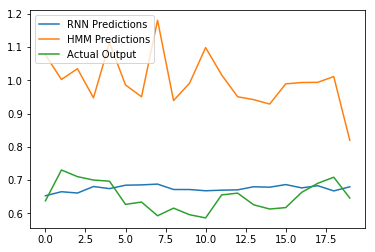

In [12]:
print('RNN predictions, layers = 2, RNN cells = 50 timesteps = 75')
x = np.arange(20)
plt.plot(x,rnn_preds)
plt.plot(x,hmm_preds)
plt.plot(x,y)

plt.legend(['RNN Predictions', 'HMM Predictions', 'Actual Output'], loc='upper left')

plt.show()